In [1]:
import pandas as pd
import ast
import json
import numpy as np
import matplotlib.pyplot as plt
import re
import collections, functools, operator

import nltk
from nltk import tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer

from PIL import Image, ImageOps
from imageai.Detection import ObjectDetection
from collections import Counter
import skimage as ski
import os
import cv2
import glob

nltk.download('punkt')
nltk.download('stopwords')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[nltk_data] Downloading package punkt to /Users/alina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/alina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Проблематика

Почему важно уметь строить качественные мультимодальные эмбеддинги? Как они используются?

Мультимодальные эмбеддинги - эмбеддинги, при построении которых используются данные нескольких модальностей (например, картинки и текст). Они предоставляют более точные результаты, чем унимодальные эмбеддинги, так как такие модели обрабатывают несколько типов информации, и имеют возможность сопоставить разные источники данных.

Унимодальные эмбеддинги хуже показывают себя в сложных сценариях: например, модель, работающая только с текстом, может быть плоха в различении товаров "компьютер" и "игрушечный компьютер", где важную роль играет изображение, и наоборот, модель, анализирующая только изображения, не сможет отличить "телефон" от "чехла для телефона". Более того, в некоторых ситуациях, таких как сопоставление поискового запроса с имеющимися товарами, не обойтись без визуальной репрезентации: например, запросы "красивая кофта" или "кружка в цветах флага России" напрямую аппелируют к визуальному восприятию товара и информации с изображения, поэтому без картинки подобрать подходящие товары будет сложнее. 

Так, унимодальные эмбеддинги снижают потенциальное качество работы маркетплейса, что напрямую влияет на опыт пользователей негативно, поэтому мы заинтересованы в применении мультимодальных эмбеддингов.

Мультимодальные эмбеддинги могут быть использованы для:

- улучшения и актуализации индивидуальных рекомендаций пользователей 
- более точного подбора рекламных предложений
- сопоставлению и сравнению описания и фото товара (соответствует ли название изображению и наоборот)
- отбору некачественных/неподходящих/нерелевантных изображений в карточках товаров
- улучшению работы поиска (показу более актуальных/похожих товаров под запрос пользователя) с
 изображениями и описаниями


Неподходящие рекомендации, некачественный поиск, неточное представление продукта сильно влияет на опыт пользователя, снижает вероятность покупки товара, создает негативное впечатление о маркетплейсе, а мультимодальные эмбеддинги, способные улучшить все эти аспекты работы сервиса, наоборот, улучшают пользовательский опыт. Например, маркетплейс eBay при переходе на мультимодальные эмбеддинги отметил увеличение коэффициента перехода по ссылке на 15,9%, рост коэффициента покупки по ссылке на 31,5%*. Таким образом, мультимодальные эмбеддинги имеют большой потенциал для развития маркетплейса и повышения лояльности полльзователей.

Источник:

https://innovation.ebayinc.com/tech/engineering/beyond-words-how-multimodal-embeddings-elevate-ebays-product-recommendations/#:~:text=From%20data%20analysis%2C%20we%20found,text%20descriptions%20and%20cover%20images.

Описание задачи: получить модель классификации товаров с помощью мультмодальных эмбеддингов и разработать методику ее оценки при помощи заданных прокси-метрик

Цель: фильтрация одинаковых товаров, улучшение пользовательского опыта, повышение коэффициентов перехода по ссылке и продаж по ссылке

Сроки: с 7 марта 2024 года по 17 мая 2024 года

Критерии оценки: качество работы классификатора, определение одинаковых товаров с отличающимися изображением или описанием

## EDA:

### 1. Базовый анализ данных
### 2. UPD Анализ текстовых данных (названия, описания)
### 3. UPD Анализ характеристик
### 4. UPD Анализ изображений

### 1. Базовый анализ данных

Выгрузим и подвергнем предобработке тренировочный датасет (датасет для валидации не включаем, потому что не хотим допустить утечки, стараясь избежать того, что датасет для валидации может повлиять на решения по поводу выбора модели или обработки тренировочного датасета).

In [3]:
train_parquet = r'/Users/alina/Desktop/WBTECH/wb_school_train.parquet'
train = pd.read_parquet(train_parquet, engine = 'auto')
train

,nm,title,description,characteristics
56869,146066373,Трилогия Метро 2033 Глуховский,ВОЗРАСТНОЕ ОГРАНИЧЕНИЕ 18+ «НАСТОЯЩИЙ МАТЕРИАЛ...,"b""[{'charcName': '\xd0\xa1\xd1\x82\xd1\x80\xd0..."
116591,70199289,Детский ксилофон-сортер 0+,Машинка-автобус - станет прекрасным подарком ...,"b""[{'charcName': '\xd0\xa1\xd1\x82\xd1\x80\xd0..."
122485,139778805,Бутсы шиповки сороконожки подростковые мужские...,Бутсы футзальные для игры в зале. Комфортная и...,"b""[{'charcName': '\xd0\xa1\xd1\x82\xd1\x80\xd0..."
74678,61390113,Рюкзак кожаный,Рюкзак женский кожаный изготовлен из экокожи п...,"b""[{'charcName': '\xd0\x9f\xd0\xbe\xd0\xbb', '..."
109425,12411967,Чешки спортивные,Чешки спортивные для детей и взрослых предназн...,"b""[{'charcName': '\xd0\x9f\xd0\xbe\xd0\xbb', '..."
...,...,...,...,...
89006,135290303,Тактические перчатки военные,Вы ищете стильные и удобные мужские перча...,"b'b\'b\\\'[{""charcName"":""\\\\\\\\u0420\\\\\\\\..."
45773,143789400,Тройник разветвитель для садовых шлангов на 1/...,"Служит для соединения трех шлангов, рукавов, т...","b""[{'charcName': '\xd0\x92\xd1\x8b\xd1\x81\xd0..."
53755,43236863,Дождик Занавес для фотозоны на праздник 2 шт.,"Не знаете чем украсить ваш праздник, для этого...","b""[{'charcName': '\xd0\xa1\xd1\x82\xd1\x80\xd0..."
47453,94728731,Серьги ассиметрия,Серьги бижутерные женские - ассиметрия. В комп...,"b""[{'charcName': '\xd0\xa8\xd0\xb8\xd1\x80\xd0..."


Заметим, что столбец характеристик закодирован в байтовом формате. Причем некоторые из строк закодированы несколько раз (3 префикса b вместо одного). 

Строки, которые закодированы один раз, имеют измененный синтаксис и могут быть расшифрованы только в формат str, но их достаточно расшифровать только один раз для получения содержания:

In [4]:
first_string = train['characteristics'][56869]

first_string = first_string.decode()

first_string

"[{'charcName': 'Страна производства', 'charcSort': 0.0, 'charcType': 1.0, 'charcValues': array(['Россия'], dtype=object), 'groupName': None, 'groupSort': 0.0, 'isUnifying': None, 'isVariable': None, 'unitName': None, 'value': None, 'valueNames': array(['Россия'], dtype=object), 'visibility': True}\n {'charcName': 'Серия', 'charcSort': 0.0, 'charcType': 1.0, 'charcValues': array(['Метро 2033'], dtype=object), 'groupName': None, 'groupSort': 0.0, 'isUnifying': None, 'isVariable': None, 'unitName': None, 'value': None, 'valueNames': array(['Метро 2033'], dtype=object), 'visibility': True}\n {'charcName': 'Высота упаковки', 'charcSort': 0.0, 'charcType': 4.0, 'charcValues': None, 'groupName': 'Габариты', 'groupSort': 0.0, 'isUnifying': None, 'isVariable': None, 'unitName': 'см', 'value': 5.0, 'valueNames': None, 'visibility': False}\n {'charcName': 'Вид бумаги', 'charcSort': 0.0, 'charcType': 1.0, 'charcValues': array(['офсетная'], dtype=object), 'groupName': None, 'groupSort': 0.0, 'isUn

Строки, закодированные несколько раз, расшифровывают в исходный формат данных (список), так как их синтаксис не изменен, но к ним необходимо применять функцию расшифровки несколько раз подряд.

In [5]:
second_string = train['characteristics'][89006]

second_string = ast.literal_eval(second_string.decode())
second_string = ast.literal_eval(second_string.decode())
second_string = ast.literal_eval(second_string.decode())

print(second_string)

[{'charcName': 'Рисунок', 'charcValues': ['милитари камуфляж']}, {'charcName': 'Номер декларации соответствия', 'charcValues': ['ЕАЭС N RU Д-RU.РА08.В.67676/22']}, {'value': 22, 'unitName': 'см', 'charcName': 'Длина упаковки', 'groupName': 'Габариты'}, {'charcName': 'Декоративные элементы', 'charcValues': ['камуфляж']}, {'charcName': 'Материал подкладки', 'charcValues': ['хлопковая ткань']}, {'charcName': 'Повод', 'charcValues': ['23 февраля', 'День Победы']}, {'charcName': 'Страна производства', 'charcValues': ['Россия']}, {'charcName': 'Сезон', 'charcValues': ['демисезон', 'круглогодичный', 'лето']}, {'charcName': 'Комплектация', 'charcValues': ['пара перчаток']}, {'value': 16, 'unitName': 'см', 'charcName': 'Ширина упаковки', 'groupName': 'Габариты'}, {'charcName': 'Особенности перчаток/варежек', 'charcValues': ['защитные вставки', 'без пальцев', 'мембранная ткань']}, {'charcName': 'Фактура материала', 'charcValues': ['Текстильная ткань']}, {'charcName': 'Назначение подарка', 'charc

Расшифруем данные методом, предложенным на ознакомительной встрече направления (повторная расшифровка с применением типов кодирования utf-8 и unicode_escape).

In [6]:
def is_encoded(s): 

    """
    Функция определяет, закодирована ли строка, с помощью метода, применяемого функцией json.detect_encoding() - считывания начального префикса.
    Возвращает булевое значение в соответствии с ответом: True - да, False - нет.
    """
    if s.startswith('b'):
        return True
    else:
        return False
        
def decode_data(s):

    """
    Функция последовательно декодирует исходные данные: сначала проводит декодировку для данных, закодированных один раз, потом проверяет,
    остались ли данные закодированными, после чего применяет повторную декодировку utf-8 и unicode_escape.
    """
    decoded_string = s.decode('utf-8')
    if is_encoded(decoded_string):
        decoded_string = ast.literal_eval(decoded_string).decode('utf-8')
        if is_encoded(decoded_string):
            decoded_string = ast.literal_eval(decoded_string).decode('unicode_escape')
    return decoded_string

In [7]:
train['characteristics'] = train['characteristics'].apply(decode_data)

In [8]:
train['characteristics']

56869     [{'charcName': 'Страна производства', 'charcSo...
116591    [{'charcName': 'Страна производства', 'valueNa...
122485    [{'charcName': 'Страна производства', 'visibil...
74678     [{'charcName': 'Пол', 'charcSort': None, 'char...
109425    [{'charcName': 'Пол', 'charcValues': ['Девочки...
                                ...                        
89006     [{"charcName":"Рисунок","charcValues":["милита...
45773     [{'charcName': 'Высота упаковки', 'charcSort':...
53755     [{'charcName': 'Страна производства', 'charcSo...
47453     [{'charcName': 'Ширина упаковки', 'charcSort':...
55639     [{'charcName': 'Жанры/тематика', 'charcSort': ...
Name: characteristics, Length: 99782, dtype: object

Данные декодированы.

In [9]:
print("Количество строк и столбцов соответственно: ", train.shape)
print("Названия фичей: ", train.columns)
print("Типы данных фичей:\n", train.dtypes)

Количество строк и столбцов соответственно:  (99782, 4)
Названия фичей:  Index(['nm', 'title', 'description', 'characteristics'], dtype='object')
Типы данных фичей:
 nm                  int64
title              object
description        object
characteristics    object
dtype: object


Проверим датасет на наличие пустых значений:

In [10]:
print("Количество пустых значений: \n", train.isna().sum())

Количество пустых значений: 
 nm                   0
title              450
description        219
characteristics      0
dtype: int64


In [11]:
pd.options.display.max_colwidth = 5000
empty_titles = train.loc[train['title'].isna()]
empty_titles

nm title  \
36564   149959253  None   
10277    92778653  None   
46777   159382967  None   
113614   96858278  None   
14854    29684619  None   
...           ...   ...   
8269     90119905  None   
19215    42955588  None   
1342     94063732  None   
8740     94224233  None   
95805    81729807  None   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [12]:
empty_descriptions = train.loc[train['description'].isna()]
empty_descriptions

nm                                                    title  \
64536   152937320         Растяжка на коляску/кроватку Гирлянда, р-р 59-80   
72519    21119223               Кружка именная  подарок Виктор всегда прав   
99909   150001638                                         TOP FLEX REBOUND   
1581     98660072                                    1 пара набоек Bissell   
103272   21616712  Пюре яблоко, малина и вишня с 5 месяцев, 100гр (6 штук)   
...           ...                                                      ...   
82872   166097312                                                Кроссовки   
120802   57823964        Хайнц - кашка мол. гречневая, 4 мес., 180/2 штуки   
52591   116871922                   Рожки дьявола ободок/Чертика/Хэллоуин/   
41519    11915107       Кашпо деревянное с 5 вазами колбами "Рамка Экстра"   
17116   163377340                                      Коляска прогулочная   

       description  \
64536         None   
72519         None   
99909         None   
1581          None   
103272        None   
...            ...   
82872         None   
120802        None   
52591         None   
41519         None   
17116         None   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

В датасете есть пустые значения. При рассмотрении тех строк, где отсутствует название либо описание, нет каких-либо видимых отличий от полностью заполненных карточек (по крайней мере на первый взгляд), так что на данном этапе нельзя сделать выводы, существует ли какая-либо связь между фактом отсутствия данных и свойствами этих данных в полупустых карточках (относятся ли пустые значения к классу NMAR). Возможно, продавцы просто не посчитали нужным заполнить описания и намеренно оставили их пустыми, возможно, произошла ошибка с заполнением или хранением данных. 

Учитывая малую долю пустых строк относительно размеров датасета, предварительно можно сказать, что вряд ли можно будет найти существенное отличие от других данных и как-то его применить в практическом ключе. Поскольку мы имеем дело с текстовыми данными, и значения для каждой карточки индивидуальны, мы никак не сможем восстановить данные или заполнить их иным методом. Всего в датасете без учета пересечений присутствует 669 пустых значений, их доля от суммарного количества значений составляет 0.67%, это статистически незначимое количество, и для дальнейшей работы в целях избежания ошибок и неудобств оптимальным выбором будет удаление строк с пустыми ячейками. На мой взгляд, поиск связи между особенностями данных и отсутствием описаний/названий имеет мало смысла, так как данные заполнялись людьми, а не считывались автоматически, и с большой долей вероятности здесь роль играет человеческий фактор. 

In [13]:
train = train.dropna()
pd.options.display.max_colwidth = 200

Проверим наличие дубликатов в датасете:

In [14]:
train.loc[train.duplicated()]

,nm,title,description,characteristics


Дубликатов нет, однако может встретиться ситуация, когда разным товарам присвоен один идентификатор (дублирование идентификатора). Проведем проверку, имеет ли место быть данная ситуация в датасете:

In [15]:
train.loc[train.duplicated(subset=['nm'])]

,nm,title,description,characteristics


Дубликатов идентификаторов нет.

### 2. Анализ текстовых данных (названия, описания)

In [16]:
# Создадим информационный датасет для хранения статистики о текстовых данных

train_info = pd.DataFrame()
train_info['nm']=train['nm']

# Определим функцию подсчета слов

def word_count(review):
    review_list = review.split()
    return len(review_list)

In [17]:
# Для названий
# Подсчитаем длину названия в символах, число слов в названии, среднюю длину слова в названии
# Укажем усредненные показатели по датасету


train_info['title_length'] = train['title'].str.len()
train_info['title_word_count'] = train['title'].apply(word_count)
train_info['title_mean_word_length'] = train['title'].map(lambda title: np.mean([len(word) for word in title.split()]))

print("Среднее число знаков в названии: ", train_info['title_length'].mean())
print("Среднее количество слов в названии: ", train_info['title_word_count'].mean())
print("Средняя длина слов в названии: ", train_info['title_mean_word_length'].mean())

train_info

Среднее число знаков в названии:  39.59476827472106
Среднее количество слов в названии:  5.826130379516979
Средняя длина слов в названии:  6.250682036267207


,nm,title_length,title_word_count,title_mean_word_length
56869,146066373,30,4,6.750000
116591,70199289,26,3,8.000000
122485,139778805,55,6,8.333333
74678,61390113,14,2,6.500000
109425,12411967,16,2,7.500000
...,...,...,...,...
89006,135290303,29,3,8.666667
45773,143789400,51,7,6.428571
53755,43236863,45,8,4.750000
47453,94728731,17,2,8.000000


# UPD Анализ максимальных и минимальных значений

Посмотрим на минимальные и максимальные значения по этим параметрам:

In [18]:
print("Минимальное число знаков в названии: ", min(train_info['title_length']))
print("Минимальное количество слов в названии: ", min(train_info['title_word_count']))
print("Минимальная длина слов в названии: ", min(train_info['title_mean_word_length']))

Минимальное число знаков в названии:  1
Минимальное количество слов в названии:  1
Минимальная длина слов в названии:  1.0


In [19]:
train.loc[train_info['title_mean_word_length'] == 1.0]

,nm,title,description,characteristics
43823,21158909,а,,"[{'charcName': 'Страна производства', 'charcSort': None, 'charcType': None, 'charcValues': array(['Китай'], dtype=object), 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariable': N..."
118304,127907960,1,не для продажи,"[{'charcName': 'Комплектация', 'valueNames': ['трубка и 5 сеток в комплекте'], 'visibility': False, 'charcValues': ['трубка и 5 сеток в комплекте']}, {'value': 10, 'unitName': 'см', 'charcName': '..."
99900,94673855,*,"При подборе размера смотрите верхнюю строчку. То есть первое значение-это размер обуви, а через тире-замер стельки в см. Очень лёгкая и мягкая обувь. Для активного отдыха и прогулки. Не уступает ...","[{'charcName': 'Назначение обуви', 'charcValues': ['Футбола']}, {'value': 25, 'unitName': 'см', 'charcName': 'Длина упаковки'}, {'charcName': 'ТНВЭД', 'charcValues': ['6403999300']}, {'charcName':..."
127570,138783308,1,не для продажи,"[{'charcName': 'Комплектация', 'valueNames': ['трубка и 5 сеток в комплекте'], 'visibility': False, 'charcValues': ['трубка и 5 сеток в комплекте']}, {'value': 20, 'unitName': 'г', 'charcName': 'В..."


Мы видим, что товары с названием, состоящим из одного символа, зачастую не имеют описания и даже самими продавцами не рассматриваются как товары: это лишние данные, которые следует удалить перед тем, как работать с каким-либо алгоритмом. Даже, если название присутствует, информация остается неполной, и так как этих данных статистически малое количество (что видно из распределения).

In [20]:
print("Максимальное число знаков в названии: ", max(train_info['title_length']))
print("Максимальное количество слов в названии: ", max(train_info['title_word_count']))
print("Максимальная длина слов в названии: ", max(train_info['title_mean_word_length']))

Максимальное число знаков в названии:  100
Максимальное количество слов в названии:  22
Максимальная длина слов в названии:  59.0


In [21]:
train.loc[train_info['title_mean_word_length'] >= 40.0]

,nm,title,description,characteristics
74485,75596529,Кредитница/Кошелек/Монетница/Визитница/МАЛЕНЬКИЙ/в/сумку,"КРЕДИТНИЦА ОЧЕНЬ МАЛЕНЬКАЯ, МИНИ КОШЕЛЕК, кредитница женская, кредитница мужская, кредитница детская, ВИЗИТНИЦА, визитница женская, визитница мужская, визитница детская, КАРТХОЛДЕР, картхолдер мал...","[{'charcName': 'Длина упаковки', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': 'Габариты', 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': 'см', 'v..."
3183,70667552,Вафельница/бутербродница/электровафельница,"Электрическая вафельница DASWERK подходит для приготовления венских, бельгийских, овощных, сырных и других видов вафель. Тип товара: вафельница. Тип управления: ручное. Количество отделений: 1. Ко...","[{'charcName': 'Гарантийный срок', 'charcSort': None, 'charcType': None, 'charcValues': array(['1 год'], dtype=object), 'groupName': 'Общие характеристики', 'groupSort': None, 'isUnifying': None, ..."
74423,90540074,Кошелек/Монетница/Кредитница/Визитница/ОЧЕНЬ/МАЛЕНЬКИЙ/МИНИ,"КОШЕЛЕК МИНИ, ОЧЕНЬ МАЛЕНЬКИЙ, 1 ОТДЕЛЕНИЕ, кошелек маленький, кошелек женский, кошелек мужской, кошелек детский, КРЕДИТНИЦА, кредитница женская, кредитница мужская, кредитница детская, ВИЗИТНИЦА,...","[{'charcName': 'Дата регистрации сертификата/декларации', 'charcSort': 0.0, 'charcType': 1.0, 'charcValues': array(['17.08.2023'], dtype=object), 'groupName': None, 'groupSort': 0.0, 'isUnifying':..."
15804,142746284,Уэнсдей|Уенсндей|Венсдей|Вэнсдей|Уэнздей|Wednesday|Аддамс,"Оригинальная детская футболка (для девочек/для мальчиков/унисекс) с эксклюзивным принтом Уэнздей Уэнсдей Уенсндей Венсдей Вэнсдей Уэнздей Wednesday Подросток- Гот Семейка Аддамс ( Гомес, Мортиша,...","[{'charcName': 'Ширина упаковки', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': 'Габариты', 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': 'см', '..."
99058,41364615,Зажигалка/Электронная/USB/спиральная/синяя,"Зажигалка слайдер имеет ряд преимуществ:- Зажигалка, работающая без газа и бензина- Прикуривание происходит через спираль, которая нагревается от сдвига лицевой панели- Достаточно короткое время з...","[{'charcName': 'Комплектация', 'charcValues': ['Зажигалка - 1 шт']}, {'charcName': 'Тип зажигалки', 'charcValues': ['электрическая']}, {'value': 2, 'unitName': 'см', 'charcName': 'Ширина предмета'..."
14758,142746329,Уэнсдей|Уенсндей|Венсдей|Вэнсдей|Уэнздей|Wednesday|Аддамс,"Оригинальная детская футболка (для девочек/для мальчиков/унисекс) с эксклюзивным принтом Уэнздей Уэнсдей Уенсндей Венсдей Вэнсдей Уэнздей Wednesday Подросток- Гот Семейка Аддамс ( Гомес, Мортиша,...","[{'charcName': 'Ширина упаковки', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': 'Габариты', 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': 'см', '..."
16144,142746286,Уэнсдей|Уенсндей|Венсдей|Вэнсдей|Уэнздей|Wednesday|Аддамс,"Оригинальная детская футболка (для девочек/для мальчиков/унисекс) с эксклюзивным принтом Уэнздей Уэнсдей Уенсндей Венсдей Вэнсдей Уэнздей Wednesday Подросток- Гот Семейка Аддамс ( Гомес, Мортиша,...","[{'charcName': 'Ширина упаковки', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': 'Габариты', 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': 'см', '..."


In [22]:
train.loc[train_info['title_length'] == 100]

,nm,title,description,characteristics
119138,76463892,Перезаправляемые картриджи ПЗК PGI-470 / CLI-471XL для Canon PIXMA TS5040 / MG5740 / TS6040 / MG6840,Комплект перезаправляемых картриджей (ПЗК) PGI-470 / CLI-471XL увеличенной емкости (БЕЗ ЧЕРНИЛ) для струйных принтеров и МФУ Canon (5 ЦВЕТОВ) подходят для моделей принтеров: Canon TS5040 / TS6040 ...,"[{'value': 220, 'unitName': 'г', 'charcName': 'Вес товара с упаковкой (г)'}, {'value': 12, 'unitName': 'см', 'charcName': 'Ширина упаковки'}, {'value': 8, 'unitName': 'см', 'charcName': 'Высота уп..."
120613,51166184,Праздничная повязка бантик Снежинка кружевная новорождённому ребёнку девочке на голову ободок корона,Повязка - бантик для новорожденных девочек в виде снежинки. Ручная работа. Детский подарок с новогодней композицией из блестящей снежинки прекрасно дополнит зимний образ девочек до 3 лет. Повязка ...,"[{'value': 4, 'unitName': 'см', 'charcName': 'Ширина предмета'}, {'value': 15, 'unitName': 'см', 'charcName': 'Ширина упаковки'}, {'value': 1, 'unitName': 'см', 'charcName': 'Высота упаковки'}, {'..."
116695,13968657,Чехол держатель для медиаторов для акустической гитары электрогитары укулеле бас гитары инструментов,"Каждый музыкант, как профессионал, так и любитель, оценит удобную деталь, как кассетницу чехол для медиаторов, которая крепится на двусторонний скотч на гитару или инструмент. Теперь медиаторы все...","[{'value': 10, 'unitName': 'мм', 'charcName': 'Толщина (мм)', 'visibility': True}, {'value': 5, 'unitName': 'г', 'charcName': 'Вес товара с упаковкой (г)', 'visibility': True}, {'value': 5, 'unitN..."
43954,66856650,"Клемма ""мама"" серия 6,3мм К1, колодочная, комплект 100 шт под провод от 0,50 до 1,00 мм кв., луженая","Предназначена для соединения с клеммой ""типа"" папа (штырь) серии 6,3 мм арт.8004 1 2 3 4 или аналогичной, и установке в гнездовые соединительные колодки различного типа, соответствующей серии. Опр...","[{'charcName': 'Вес товара с упаковкой (г)', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': 'г..."
106280,15062137,Кольцевая лампа цветная 33 см 26 со штативом 2 м RGB Bluetooth пульт tik tok тик ток световое кольцо,"Кольцевая лампа 33 см со штативом RGB отлично подойдёт для тик токеров, блоггеров и визажистов, работающих по вызову, ведь её спокойно можно брать c собой. Разные цвета дадут самый необычный свет,...","[{'value': 1, 'unitName': 'кг', 'charcName': 'Вес с упаковкой (кг)', 'groupName': 'Габариты', 'visibility': True}, {'value': 33, 'unitName': 'см', 'charcName': 'Высота предмета', 'groupName': 'Габ..."
...,...,...,...,...
123089,72517452,"Храповик стартера для бензокосы CARVER, FORZA, BRAIT плата собачек триммера китайского бензотриммера","Плата собачек, храповик стартера с собачками, для китайского бензотриммера CARVER, FORZA, BRAIT, Техас, Калибр с объемом двигателя 33 см3, 43 см3, 52 см3.","[{'value': 70, 'unitName': 'г', 'charcName': 'Вес товара с упаковкой (г)'}, {'value': 50, 'unitName': 'г', 'charcName': 'Вес товара без упаковки (г)'}, {'value': 2, 'unitName': 'см', 'charcName': ..."
73087,75215051,Исламские часы Al-Harameen 6504BBM с ремешками миланского плетения. Оригинальный подарок мусульманам,Вашему вниманию предлагаются исламские наручные часы Al-Harameen HA-6504 BBM (Черные) с ремешками миланского плетения . Одна из самых расспространенная модель. Подходят для мужчин и для женщин. Ча...,"[{'charcName': 'Ширина упаковки', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': 'Габариты', 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': 'см', '..."
123104,65671641,"Стартер для бензотриммера, бензокосы 33, 43, 52 см3 усы, две проволочки, Carver, Huter, Brait, Forza","Ручной стартер двигателя (усы, две проволоки) для бензотриммера (для триммера, бензокосы) с объемом двигателя 33, 43, 52 см3. Запчасти для садовой техники - высокого качества. Подходит на многие к...","[{'value': 250, 'u

Названия с максимальным количеством символов имеют особенности форматирования, которые не учитывает текущая токенизация (разделение слов не пробелом, а вертикальной либо косой чертой). Это можно учесть и удалять их не обязательно, особенно при условии, что мы уже можем заметить наличие дубликатов под разными идентификационными номерами, что нам поможет в будущем их определять.

Названия с максимальным количеством слов не имеют особенностей: по всей видимости, продавцы просто пользуются лимитом слов на название и записывают туда максимальное количество характеристик.

In [23]:
# Для описаний
# Подсчитаем длину описания в символах, число слов в описании, среднюю длину слова в описании
# Укажем усредненные показатели по датасету

train_info['description_length'] = train['description'].str.len()
train_info['description_word_count'] = train['description'].apply(word_count)
train_info['description_mean_word_length'] = train['description'].map(lambda title: np.mean([len(word) for word in title.split()]))

print("Среднее число знаков в описании: ", train_info['description_length'].mean())
print("Среднее количество слов в описании: ", train_info['description_word_count'].mean())
print("Средняя длина слов в описании: ", train_info['description_mean_word_length'].mean())


Среднее число знаков в описании:  1151.3069023263322
Среднее количество слов в описании:  157.70395254524544
Средняя длина слов в описании:  6.424253446645302


In [24]:
print("Минимальное число знаков в  описании: ", min(train_info['description_length']))
print("Минимальное количество слов в описании: ", min(train_info['description_word_count']))
print("Минимальная длина слов в описании: ", min(train_info['description_mean_word_length']))

Минимальное число знаков в  описании:  0
Минимальное количество слов в описании:  0
Минимальная длина слов в описании:  1.0


In [25]:
train.loc[train_info['description_mean_word_length'] == 1.0]

,nm,title,description,characteristics
99024,97994857,CH,J,"[{'value': 200, 'unitName': 'г', 'charcName': 'Вес товара с упаковкой (г)'}, {'value': 8, 'unitName': 'см', 'charcName': 'Ширина предмета'}, {'value': 7, 'unitName': 'см', 'charcName': 'Длина упак..."


In [26]:
train.loc[train_info['description_length'] == 0]

,nm,title,description,characteristics
100238,137375180,"Конус посадочный для рассады цветов сада, сажалка для семян",,"[{'value': 14, 'unitName': 'см', 'charcName': 'Ширина упаковки', 'groupName': 'Габариты', 'visibility': True}, {'charcName': 'Материал изделия', 'groupName': 'Материалы', 'visibility': True, 'char..."
82161,111300150,Туфли,,"[{'charcName': 'Пол', 'charcSort': None, 'charcType': None, 'charcValues': array(['Женский'], dtype=object), 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName..."
104783,37245603,Шкив для культиватора Крот d20мм,,"[{'value': 10, 'unitName': 'см', 'charcName': 'Ширина упаковки'}, {'value': 35, 'unitName': 'см', 'charcName': 'Высота упаковки'}, {'charcName': 'Комплектация', 'charcValues': ['Шкив 1шт']}, {'val..."
42490,147993528,Рамка для номера серебро Toyota,,"[{'charcName': 'Страна производства', 'charcSort': None, 'charcType': None, 'charcValues': array(['Россия'], dtype=object), 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariable': ..."
30383,14782872,Шапка PERF WOOLIE ROYBLU/BLACK/WHITE,,"[{'charcName': 'Пол', 'charcSort': None, 'charcType': None, 'charcValues': array(['Мужской'], dtype=object), 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName..."
...,...,...,...,...
116478,3899114,Акваноски SPLASH,,"[{'charcName': 'Состав', 'charcValues': ['полиамид', 'эластан', 'полиэстер', 'резина']}, {'charcName': 'Страна производства', 'charcValues': ['Малайзия']}, {'charcName': 'ТНВЭД', 'charcValues': ['..."
82785,28313419,Эспадрильи,,"[{'charcName': 'Материал подкладки обуви', 'charcSort': None, 'charcType': None, 'charcValues': array(['искусственная кожа'], dtype=object), 'groupName': None, 'groupSort': None, 'isUnifying': Non..."
35844,30051279,Тайтсы Piping Pack Poly Ti BLACK,,"[{'charcName': 'Коллекция', 'charcSort': None, 'charcType': None, 'charcValues': array(['Осень-Зима 2021-2022'], dtype=object), 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariabl..."
99904,131497167,TOP FLEX,,"[{'charcName': 'Коллекция', 'charcValues': ['весна-лето 23']}, {'value': 20, 'unitName': 'см', 'charcName': 'Ширина упаковки', 'groupName': 'Габариты'}, {'charcName': 'Пол', 'charcValues': ['Мужск..."


Видим, что описания с минимальными значениями посчитанных параметров представляют из себя либо неправильно заполненные карточки, либо незаполненные вообще (пустое описание, которое не было считано при подсчете пустых значений - вероятно, из-за того, что было заполнено пробелом). Подобные данные представляют собой статистически незначимую величину и от них тоже можно избавиться, поскольку описание - важная для нас характеристика, и мы не хотим искажать качество модели данными, где ее нет.

In [27]:
print("Максимальное число знаков в названии: ", max(train_info['description_length']))
print("Максимальное количество слов в названии: ", max(train_info['description_word_count']))
print("Максимальная длина слов в названии: ", max(train_info['description_mean_word_length']))

Максимальное число знаков в названии:  5000
Максимальное количество слов в названии:  959
Максимальная длина слов в названии:  1999.0


In [28]:
train.loc[train_info['description_mean_word_length'] >= 1900.0]

,nm,title,description,characteristics
90505,101889706,Кольцо,"подарок,кольцо,новогодний,набор,украшение,год,новый,подарочный,бижутерия,парный,день,мама,серебро,женский,мужчина,подруга,серьга,рождение,косметика,декор,девочка,женщина,y2k,мужской,кулон,золото,м...","[{""charcName"":""Комплектация"",""valueNames"":[""женское кольцо сердце + упаковка""],""visibility"":false,""charcValues"":[""женское кольцо сердце + упаковка""]},{""charcName"":""Ограничение"",""groupName"":""Другие..."
47828,157042504,Парные кулоны,"подарок,браслет,парный,шея,набор,цепочка,подвеска,новогодний,женский,подарочный,кулон,бижутерия,подруга,мама,мужчина,украшение,год,день,новый,рождение,мужской,женщина,девочка,кольцо,y2k,серебро,ан...","[{'charcName': 'Состав бижутерии', 'charcSort': None, 'charcType': None, 'charcValues': array(['Бижутерный сплав - 100%'], dtype=object), 'groupName': None, 'groupSort': None, 'isUnifying': None, ..."


In [29]:
train.loc[train_info['description_length'] >= 4800.0]

,nm,title,description,characteristics
119330,123350447,"Лопасть, ребро с грузом ARDO, 651027984","Лопасть барабана с грузом – тяжелая, для вертикальных стиральных машин (С верхней загрузкой) ARDO, ASKO, GORENJE, KAISER, MERLONY. | Наиболее часто встречается в стиральных машинах фирмы ARDO (Ард...","[{'charcName': 'Материал изделия', 'groupName': 'Материалы', 'charcValues': ['пластмасса']}, {'charcName': 'Совместимость', 'charcValues': ['ARDO', 'Gorenje', 'Asko', 'Kaiser', 'MERLONY']}, {'char..."
20855,142895925,"Кухонный фартук на стену, зеркальная мозаика 5шт (0,48 квм)","Если вы хотите создать интересный дизайн своих стен, то декоративная зеркальная плитка мозаика на стену для кухни - это идеальный вариант для вас. Этот отделочный материал плитка мозаика отличаетс...","[{'charcName': 'Состав', 'charcSort': None, 'charcType': None, 'charcValues': array(['зеркальная мозаика', 'мозаика плитка из зеркала',\n 'мозаика стекло', 'стеклянная мозаика', 'зеркальная..."
51648,172724770,стиральный порошок автомат для белья 10 кг,"Стиральный порошок универсальный для цветного и белого белья автомат Herr Klee Universal быстро растворяется и полностью выполаскивается из вещей, дарит безупречную чистоту и белизну. Удаление пят...","[{'charcName': 'Вес товара без упаковки (г)', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': '..."
40914,153301289,"Хорус 2г Средство для защиты растений от болезней, фунгицид","Хорус - известный препарат от монилиального ожога, коккомикоза, плодовой гнили, парши и других болезней на семечковых и косточковых плодовых культурах. Системное, защитное, лечебное действие. Быст...","[{'charcName': 'Ширина упаковки', 'charcSort': None, 'charcType': None, 'charcValues': None, 'groupName': None, 'groupSort': None, 'isUnifying': None, 'isVariable': None, 'unitName': 'см', 'value'..."
126631,140756587,Камера видеонаблюдения уличная WI-FI 360,Поворотная WiFi камера видеонаблюдения с Full HD разрешением и обзором 270 градусов обеспечит возможность наблюдать за происходящим в реальном времени из любой точки мира и с любого устройства! Да...,"[{'charcName': 'Возможность крепления на стену', 'charcValues': ['есть']}, {'charcName': 'Комплектация', 'charcValues': ['IP-камера', 'сетевой адаптер', 'крепление настенное', 'инструкция']}, {'ch..."
...,...,...,...,...
95141,124532277,"варежки детские, краги детские","Непромокаемые зимние теплые детские варежки краги ( нетеряжки, зимки, снэки, варюшки) для мальчиков и девочек - это по-настоящему незаменимый аксессуар как для снежной зимы, так и для холодной осе...","[{'value': 10, 'unitName': 'см', 'charcName': 'Ширина упаковки'}, {'value': 8, 'unitName': 'см', 'charcName': 'Высота упаковки'}, {'value': 25, 'unitName': 'см', 'charcName': 'Длина упаковки'}, {'..."
104359,157643253,Повязка на голову для малышей,"Повязка на голову для малыша - стильный и практичный аксессуар, который добавит неповторимый шарм и уют к образу вашего маленького модника. Этот головной убор идеально подойдет для новорожденных д...","[{'charcName': 'Рисунок', 'valueNames': ['нет'], 'visibility': False, 'charcValues': ['нет']}, {'charcName': 'Тип комплекта', 'valueNames': ['повязка на голову детская'], 'visibility': True, 'char..."
5631,138194825,"перчатки нитриловые, одноразовые 100 шт s, m, l","Перчатки косметические, нитриловые, косметические. Маникюрные перчатки и так далее. Называйте как угодно эти одноразовые черные перчатки, но бренд и качество останется неизменным. Бенови (benovy b...","[{'charcName': 'Комплектация', 'charcSort': None, 'charcType': None, 'charcValues': array(['упаковка одноразовых нитриловых перчаток бенови черного цвета',\n 'перчатки М С Л ХС размеров', '..."
55022,117249563,Наклейки интерактивные,"Представляем вашему вниманию наши стикеры-наклейки, с помощью которых вы легко и быстро можете изменить дизайн своих карт, подчеркнув свою индивидуальность! Стикер клеится только на одну сторон

В максимальных значениях среднего снова можно заметить нестандартное форматирование (разделение запятой без пробела), максимальное значение слов никак из общей картины данных не выбивается.

In [30]:
# Подсчитаем среднюю длину предложения в описании

train_info['description_mean_sent_length'] = train['description'].map(lambda descr: np.mean([len(sent) for sent in tokenize.sent_tokenize(descr)]))

In [31]:
train_info

,nm,title_length,title_word_count,title_mean_word_length,description_length,description_word_count,description_mean_word_length,description_mean_sent_length
56869,146066373,30,4,6.750000,1191,163,6.294479,169.285714
116591,70199289,26,3,8.000000,612,87,6.034483,203.333333
122485,139778805,55,6,8.333333,727,92,6.913043,90.000000
74678,61390113,14,2,6.500000,622,86,6.244186,88.000000
109425,12411967,16,2,7.500000,516,68,6.602941,171.333333
...,...,...,...,...,...,...,...,...
89006,135290303,29,3,8.666667,1789,240,6.275000,115.866667
45773,143789400,51,7,6.428571,111,15,6.466667,55.000000
53755,43236863,45,8,4.750000,759,115,5.608696,83.444444
47453,94728731,17,2,8.000000,934,132,6.083333,92.500000


Примечательно, что описания хорошо разделяются на предложения (средняя длина предложений ощутимо меньше, чем общая длина описаний), то есть продавцы склонны оформлять описания как цельный текст. Это может послужить подспорьем в дальнейшем анализе.

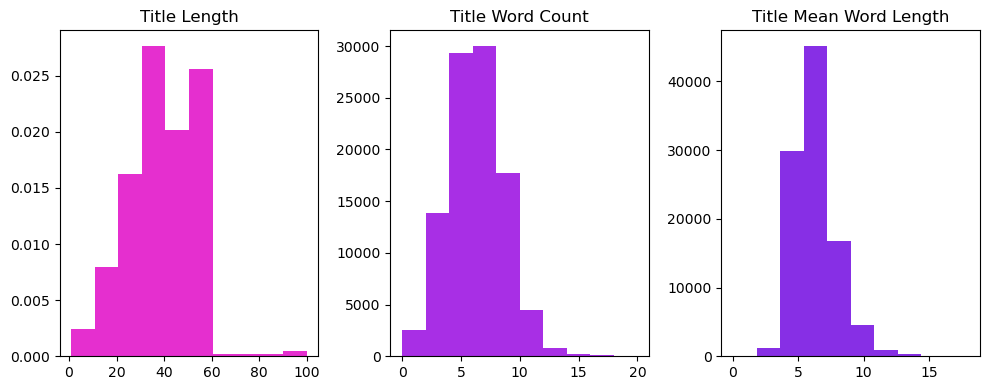

In [32]:
# Проиллюстрируем найденные показатели

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax0.hist(train_info['title_length'], density=True, histtype='bar', color='#E52FCF')
ax0.set_title('Title Length')

ax1.hist(train_info['title_word_count'], range=[0, 20], histtype='bar', color='#A82FE5' )
ax1.set_title('Title Word Count')

ax2.hist(train_info['title_mean_word_length'],  range=[0, 18], histtype='bar', color='#872FE5')
ax2.set_title('Title Mean Word Length')

fig.tight_layout()
plt.show()

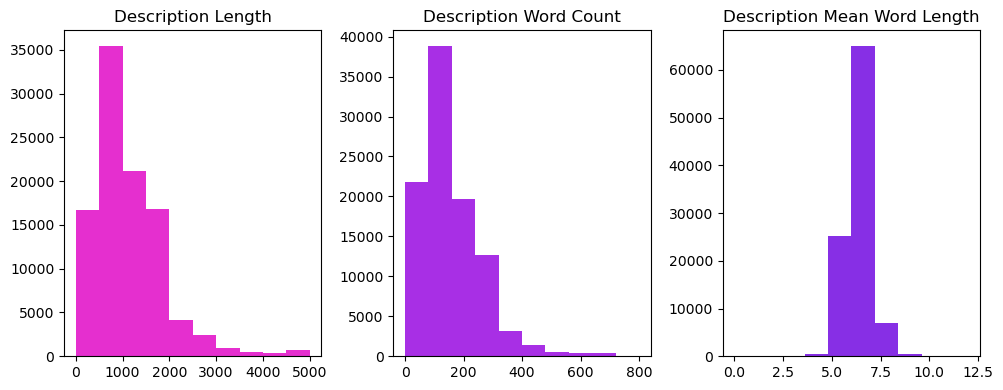

In [33]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax0.hist(train_info['description_length'], histtype='bar', color='#E52FCF')
ax0.set_title('Description Length')

ax1.hist(train_info['description_word_count'], range=[0,800], histtype='bar', color='#A82FE5' )
ax1.set_title('Description Word Count')

ax2.hist(train_info['description_mean_word_length'],  range=[0, 12], histtype='bar', color='#872FE5')
ax2.set_title('Description Mean Word Length')

fig.tight_layout()
plt.show()

### Term Frequency Analysis

Частотный анализ для названий (на первом этапе для простоты ограничимся частотным анализом без лемматизации):

In [489]:
# Небольшой препроцессинг текста: перевод символов в нижний регистр, токенизация, удаление стоп-слов, включая частотные для нашего датасета

tfa_train_titles = train['title']

russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это', 'также', 'шт'])

In [490]:
tfa_train_titles_tokenized =tfa_train_titles.apply(lambda s: nltk.word_tokenize(s))
tfa_train_titles_preprocessed = tfa_train_titles_tokenized.apply(lambda str: [c.lower() for c in str if c.isalpha()])
tfa_train_titles_clean = tfa_train_titles_preprocessed.apply(lambda str: [w for w in str if w not in russian_stopwords])

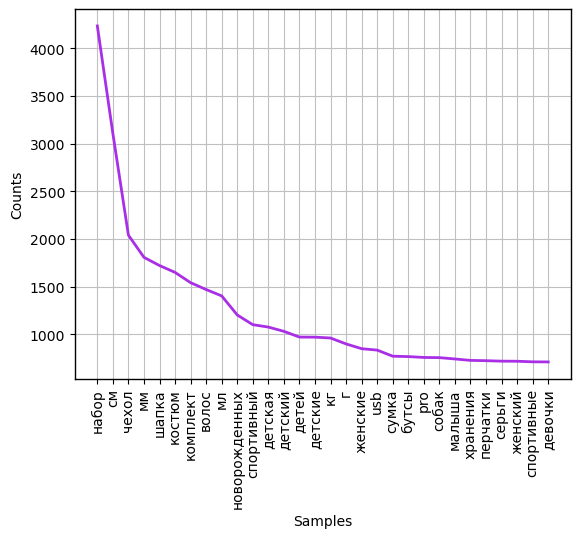

<Axes: xlabel='Samples', ylabel='Counts'>

In [491]:
# Иллюстрируем частотность

tfa_train_titles_merged = []
for word_list in tfa_train_titles_clean:
    tfa_train_titles_merged += word_list
    
fdist = FreqDist(tfa_train_titles_merged)
fdist.plot(30, cumulative=False, color = '#A82FE5')

Видим, что продавцы часто вставляют в названия меры измерений, что частично дублирует характеристики. Возможно, какие-то из частей названий или характеристик в будущем ввиду дублирования информации можно будет опустить.

Названия содержат много конкретных и содержательных слов (в отличие от описаний, как мы увидим далее), что продуктивно для дальнейшего построения эмбеддингов. 

В целом, на текущем этапе благодаря содержательности названий мы можем сложить впечатление о том, какие товары превалируют в датасете.

Частотный анализ для описаний:

In [ ]:
# Аналогичный препроцессинг

tfa_train_descriptions = train['description']

tfa_train_descriptions_tokenized =tfa_train_descriptions.apply(lambda s: nltk.word_tokenize(s))
tfa_train_descriptions_preprocessed = tfa_train_descriptions_tokenized.apply(lambda str: [c.lower() for c in str if c.isalpha()])
tfa_train_descriptions_clean = tfa_train_descriptions_preprocessed.apply(lambda str: [w for w in str if w not in russian_stopwords])

In [ ]:
# Иллюстрация

tfa_train_descriptions_merged = []
for word_list in tfa_train_descriptions_clean:
    tfa_train_descriptions_merged += word_list
fdist = FreqDist(tfa_train_descriptions_merged)
fdist.plot(30,cumulative=False, color = '#A82FE5')

Как можно заметить, тексты описаний достаточно "замусорены" общими словами, не несущими практической смысловой нагрузки для нашей задачи. Это сигнализирует о том, что в последствии их необходимо будет подвергать тщательной обработке и дополнительной чистке, потому как содержательных эмбеддингов на основе, например, эпитетов с положительными коннотациями (хороший, отличный, идеальный) нам построить не удастся. Предположу, что скорее всего понадобится также частеречная фильтрация: например, глаголы могут только мешать в данном случае, поскольку с помощью них продавцы стремятся создать рекламный эффект, но не сообщают какой-либо содержательной информации о товаре (позволяет, помогает, подойдет, обеспечивает, станет, является).

Стоит заметить, что поскольку эти общие фразы очень частотны, их нельзя будет использовать для соотносения товаров между собой: можно было предположить, что похожие по структуре/используемой лексике описания применяются для похожих товаров, и по общим сравнениям тональности/частым выражениям (не характеризующим словам) можно кластеризировать товары, присваивать им ту или иную категорию. Но анализ показывает, что описания разных товаров так или иначе похожи между собой - общие слова, создающие рекламный эффект, присутствуют почти в каждом описании, поэтому скорее всего мы будем подходить к описаниями через извлечение ключевых содержательных слов.

К тому же можно сразу сделать вывод, что в описаниях достаточно часто фигурируют размеры и габариты, что дублирует характеристики товаров во многом. Возможно, оба типа данных несут схожую или одинаковую информацию, и в будущем придется сделать упор на что-то одно. Это также заранее позволяет понять, какие характеристики или детали описаний можно отбросить, упрощая задачу в будущем.

Интересно заметить, что в описания также часто вставляют повод для покупки (подарок на день рождения, на 8 марта, на 23 февраля и подобное). С одной стороны, товар может быть тематически приурочен к празднику (например, кружка с надписью "С 8 марта") и играть содержательную роль, с другой стороны, продавцы могут просто стремиться создать стимул для покупки. Полезно это наблюдение для нас или нет еще предстоит выяснить.

### N-gram Frequency

Анализ Н-грамм, в данном случае, имеет отдельную ценность: можно заметить, что продавцы часто в описание включают не цельный текст, а разные наборы фраз или тегов, по которым пользователям при вводе запроса в поиске будет легче найти их товар. Очевидно, это не просто реклама товара, а прямое выделение ключевых признаков и отличительных характеристик. Поэтому выделение частотных Н-грамм (особенно в рамках отдельных товаров или похожих товаров) потенциально может дать много содержательной информации для создания эмбеддинга для товара.

Мощность моего компьютера, к сожалению, не позволяет мне провести анализ частотности биграмм на всем датасете. Тем не менее, для того, чтобы сложить общее впечатление о частотности биграмм в названиях и описаниях, можно рассмотреть часть данных. Так мы сможем понять, чего можно ожидать от не попавших в случайную выборку данных.

Для названий возьмем треть датасета - 35%
Для описаний возьмем одну двадцатую датасета - 5%

In [28]:
ttt_sample = tfa_train_titles.sample(frac=0.35)

In [29]:
cv_t = CountVectorizer(ngram_range=(2,2))
bigrams_t = cv_t.fit_transform(ttt_sample)
values_number_t = bigrams_t.toarray().sum(axis=0)
ngram_frequency_t = pd.DataFrame(sorted([(values_number_t[i], k) for k, i in cv_t.vocabulary_.items()], reverse = True))
ngram_frequency_t.columns = ['frequency', 'ngram']

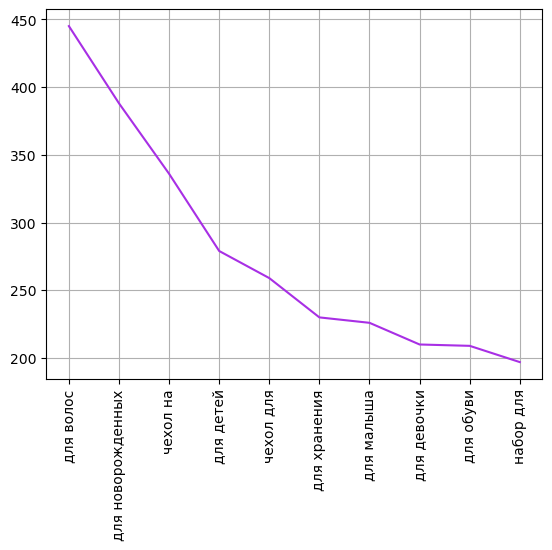

In [30]:
fig, ax = plt.subplots()
ax.plot(ngram_frequency_t['ngram'][:10], ngram_frequency_t['frequency'][:10], color='#A82FE5')
ax.tick_params(axis='x', labelrotation=90)
ax.grid()
plt.show()

Как можно заметить, самые частотные биграммы в названиях связаны с предназначением/аудиторией товара (для хранения/для детей). Это интересное наблюдение, поскольку в будущем позволит нам выделить потенциальные признаки из названий, выделить ключевые фразы при текстовом анализе, объединив их в токены.

In [31]:
ttd_sample = tfa_train_descriptions.sample(frac=0.05)

In [32]:
cv_d = CountVectorizer(ngram_range=(2,2))
bigrams_d = cv_d.fit_transform(ttd_sample)
values_number_d = bigrams_d.toarray().sum(axis=0)
ngram_frequency_d = pd.DataFrame(sorted([(values_number_d[i], k) for k, i in cv_d.vocabulary_.items()], reverse = True))
ngram_frequency_d.columns = ['frequency', 'ngram']

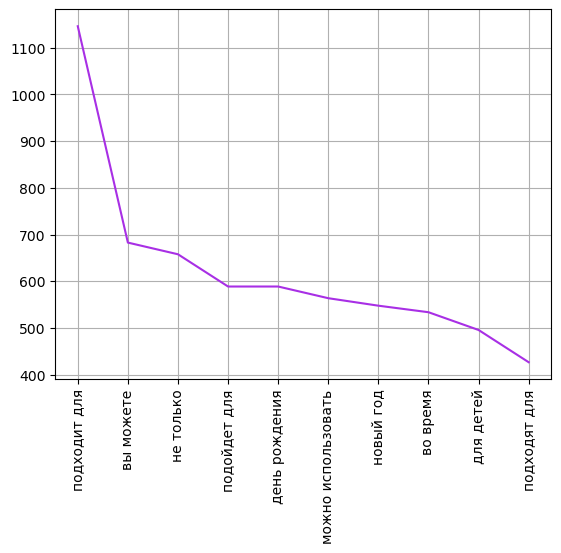

In [33]:
fig, ax = plt.subplots()
ax.plot(ngram_frequency_d['ngram'][:10], ngram_frequency_d['frequency'][:10], color='#A82FE5')
ax.tick_params(axis='x', labelrotation=90)
ax.grid()
plt.show()

Анализ частотности биграмм на описаниях показывает примерно то же, с чем мы столкнулись при анализе частотности терминов: текст наполнен общими широкоупотребимыми фразами, которые не несут смысловой нагрузки для характеристики товара (и для построения эмбеддингов). Тем не менее, объединение подобных фраз в н-граммы в будущем, вероятно, поможет быстрее и легче справляться с их детекцией и очищением.

На данном этапе я воздержалась от проведения Sentiment Analysis по двум причинам:

Во-первых, по общему анализу Term Frequency в описаниях уже можно заметить, что большая часть текстов будет отнесена к позитивной коннотации (продавцы, по понятным причинам, при заполнении карточки склонны хвалить свой товар, вставляя много положительных эпитетов). И в целом, логично предполагать, что рекламный текст, будучи созданным для привлечения покупателя, будет иметь позитивную коннотацию. Поэтому анализ тональности здесь имеет не так много смысла.

Во-вторых, построение эмбеддингов требует от нас делать упор на содержательные элементы текста, которые способны отличить один товар от другого и четко охарактеризовать его. Тональность здесь малополезна, на мой взгляд.

### Анализ характеристик

Проанализируем: как вообще выглядит пример этого типа данных? 

Он представляет из себя список словарей, каждый словарь соответствует одной характеристике.

Пример:

In [34]:
test_string = train['characteristics'][89006]
test_string

'[{"charcName":"Рисунок","charcValues":["милитари камуфляж"]},{"charcName":"Номер декларации соответствия","charcValues":["ЕАЭС N RU Д-RU.РА08.В.67676/22"]},{"value":22,"unitName":"см","charcName":"Длина упаковки","groupName":"Габариты"},{"charcName":"Декоративные элементы","charcValues":["камуфляж"]},{"charcName":"Материал подкладки","charcValues":["хлопковая ткань"]},{"charcName":"Повод","charcValues":["23 февраля","День Победы"]},{"charcName":"Страна производства","charcValues":["Россия"]},{"charcName":"Сезон","charcValues":["демисезон","круглогодичный","лето"]},{"charcName":"Комплектация","charcValues":["пара перчаток"]},{"value":16,"unitName":"см","charcName":"Ширина упаковки","groupName":"Габариты"},{"charcName":"Особенности перчаток/варежек","charcValues":["защитные вставки","без пальцев","мембранная ткань"]},{"charcName":"Фактура материала","charcValues":["Текстильная ткань"]},{"charcName":"Назначение подарка","charcValues":["любимому мужу","мужчине","сыну"]},{"charcName":"Пол"

Однако, с обработкой этих данных возникает проблема: пусть изначально они, вероятно, хранились как словари (ввиду синтаксиса строк), при кодировке они были преобразованы в строки. Причем, мы не можем преобразовать их обратно однострочными встроенными функциями ast.literal_eval() или json.loads() из-за синтаксических ошибок в строках.

Можно либо пересоздавать все словари в ручную, без встроенных функций, либо попытаться подчистить строки так, чтобы их можно было вернуть к виду словарей встроенными функциями. Я реализовала второй вариант:

In [35]:
def clean_string(string):

    """
    Функция очищает строку, исправляя ее синтаксис так, чтобы json.loads() могла ее обработать. На выходе мы получаем список строк, каждая
    из которых представляет собой словарь в формате строки, который подходит под параметры инпута json.loads() 
    """
    # Убираем символы списка первым и последним символом
    string = string[1:-1]

    # Убираем все те фрагменты, которые json.loads() не может обработать
    
    string = string.replace('array(', '')
    string = string.replace('dtype=object),', '')
    string = string.replace('\n', '')

    # Заменяем одинарные кавычки на двойные
    string = string.replace("'", '"')

    # Все значения для ключей обрамляем кавычки (синтаксис Json не предусматривает булевых значений и None)
    string = string.replace("False", '"False"')
    string = string.replace("True", '"True"')
    string = string.replace("None", '"None"')

    # Стандартизируем пробелы
    combine_whitespace = re.compile(r"\s+")
    string = combine_whitespace.sub(" ", string).strip()

    # Из-за различий в изначальной кодировке строк, при декодировке они приобрели разный вид
    # Где-то словари просто идут подряд без разделителя, где-то через запятую с пробелом, где-то просто через запятую
    # Учитывая эти различия, делим строку на отдельные строчки, каждой из которых соответствует один словарь

    if '}, ' in string:
        string = string.split("}, ")
    elif '},' in string:
        string = string.split("},")
    else:
        string = string.split("} ")

     # Последнему элементу добавляем закрывающую скобку
    
    output = [row + '}' for row in string[:-1]]
    
    return output
    
def make_dict(descr_list):

    """
    Функция применяет json.loads() к каждой очищенной и стандартизированной строке, преобразуя ее в словарь. На выходе получаем список 
    словарей, то есть тот тип данных, который изначально и был нужен.
    """
    
    list_of_dicts = []

    # Из-за непостоянного кодирования данных, в некоторых из них появляется какой-то другой, нерегулярный способ разделения,
    # выбивающийся из описанных в функции clean_string() случаев: их слишком мало, чтобы их можно было идентифицировать и учесть
    # поэтому для удобства при первичном анализе данных их легче пропустить
    # (впоследствии при более тщательной стандартизации можно будет поработать над ними)
    
    try:
        for lst in descr_list:
            dict_new = json.loads(lst)
            list_of_dicts.append(dict_new)
    except ValueError:
        pass
        
    return list_of_dicts

In [36]:
# Пример работы функции стандартизации синтаксиса clean_string():

new_string = clean_string(test_string)
new_string

['{"charcName":"Рисунок","charcValues":["милитари камуфляж"]}',
 '{"charcName":"Номер декларации соответствия","charcValues":["ЕАЭС N RU Д-RU.РА08.В.67676/22"]}',
 '{"value":22,"unitName":"см","charcName":"Длина упаковки","groupName":"Габариты"}',
 '{"charcName":"Декоративные элементы","charcValues":["камуфляж"]}',
 '{"charcName":"Материал подкладки","charcValues":["хлопковая ткань"]}',
 '{"charcName":"Повод","charcValues":["23 февраля","День Победы"]}',
 '{"charcName":"Страна производства","charcValues":["Россия"]}',
 '{"charcName":"Сезон","charcValues":["демисезон","круглогодичный","лето"]}',
 '{"charcName":"Комплектация","charcValues":["пара перчаток"]}',
 '{"value":16,"unitName":"см","charcName":"Ширина упаковки","groupName":"Габариты"}',
 '{"charcName":"Особенности перчаток/варежек","charcValues":["защитные вставки","без пальцев","мембранная ткань"]}',
 '{"charcName":"Фактура материала","charcValues":["Текстильная ткань"]}',
 '{"charcName":"Назначение подарка","charcValues":["люби

In [37]:
# Пример работы функции приведения строк к виду словарей make_dict():

new_string = make_dict(new_string)
new_string

[{'charcName': 'Рисунок', 'charcValues': ['милитари камуфляж']},
 {'charcName': 'Номер декларации соответствия',
  'charcValues': ['ЕАЭС N RU Д-RU.РА08.В.67676/22']},
 {'value': 22,
  'unitName': 'см',
  'charcName': 'Длина упаковки',
  'groupName': 'Габариты'},
 {'charcName': 'Декоративные элементы', 'charcValues': ['камуфляж']},
 {'charcName': 'Материал подкладки', 'charcValues': ['хлопковая ткань']},
 {'charcName': 'Повод', 'charcValues': ['23 февраля', 'День Победы']},
 {'charcName': 'Страна производства', 'charcValues': ['Россия']},
 {'charcName': 'Сезон',
  'charcValues': ['демисезон', 'круглогодичный', 'лето']},
 {'charcName': 'Комплектация', 'charcValues': ['пара перчаток']},
 {'value': 16,
  'unitName': 'см',
  'charcName': 'Ширина упаковки',
  'groupName': 'Габариты'},
 {'charcName': 'Особенности перчаток/варежек',
  'charcValues': ['защитные вставки', 'без пальцев', 'мембранная ткань']},
 {'charcName': 'Фактура материала', 'charcValues': ['Текстильная ткань']},
 {'charcName'

Введя новые функции, обработаем датасет:

In [38]:
char_train = train['characteristics']

In [39]:
char_train = char_train.apply(lambda s: clean_string(s))

In [40]:
char_train = char_train.apply(lambda s: make_dict(s))

In [41]:
char_train

56869     [{'charcName': 'Страна производства', 'charcSort': 0.0, 'charcType': 1.0, 'charcValues': ['Россия'], 'groupName': 'None', 'groupSort': 0.0, 'isUnifying': 'None', 'isVariable': 'None', 'unitName': ...
116591    [{'charcName': 'Страна производства', 'valueNames': ['Китай'], 'visibility': 'True', 'charcValues': ['Китай']}, {'value': 0.46, 'unitName': 'кг', 'charcName': 'Вес с упаковкой (кг)', 'groupName': ...
122485    [{'charcName': 'Страна производства', 'visibility': 'True', 'charcValues': ['Китай']}, {'charcName': 'ТНВЭД', 'visibility': 'False', 'charcValues': ['6402190000']}, {'charcName': 'Материал подклад...
74678     [{'charcName': 'Пол', 'charcSort': 'None', 'charcType': 'None', 'charcValues': ['Женский'], 'groupName': 'None', 'groupSort': 'None', 'isUnifying': 'None', 'isVariable': 'None', 'unitName': 'None'...
109425    [{'charcName': 'Пол', 'charcValues': ['Девочки']}, {'value': 30, 'unitName': 'см', 'charcName': 'Длина упаковки'}, {'charcName': 'Комплектация', 'char

In [42]:
# Создаем информационный датасет для характеристик

char_info = pd.DataFrame()
char_info['nm']=train['nm']

Найдем число характеристик для каждого товара (число словарей в каждой строке):

In [43]:
char_info['char_length'] = char_train.str.len()

In [44]:
char_info

,nm,char_length
56869,146066373,19
116591,70199289,8
122485,139778805,14
74678,61390113,17
109425,12411967,11
...,...,...
89006,135290303,20
45773,143789400,4
53755,43236863,6
47453,94728731,12


In [45]:
print("Среднее число характеристик товара: ", char_info['char_length'].mean())

Среднее число характеристик товара:  13.307729556322256


Теперь проанализируем, как часто каждое из внутренних свойств характеристики встречатеся заполненным (непустым).
Иными словами проссуммируем итоговое число заполненных характеристик каждого типа по всем товарам.

In [46]:
# Введем список названий свойств характеристик и список пустых значений

negative_values = ['False', 'None', 0]
default_char_names = ["charcName", "charcSort", "charcType", "charcValues", "groupName", "groupSort", "isUnifying", "isVariable", "unitName", "value", "valueNames", "visibility"]

In [47]:

def common_char_values(char):

    """
    Эта функция проходит по всем словарям-характеристикам товара, подсчитывая, сколько раз каждая из них встречается заполненной.
    На выходе получаем словарь, где ключ - название свойства, значение - количество раз, которое оно заполнено для одного товара.
    """ 
    
    default_char = {"charcName": 0,
                    "charcSort": 0,
                    "charcType": 0,
                    "charcValues": 0,
                    "groupName": 0,
                    "groupSort": 0,
                    "isUnifying": 0,
                    "isVariable": 0,
                    "unitName": 0,
                    "value": 0,
                    "valueNames": 0,
                    "visibility": 0}
    
    negative_values = ['False', 'None', 0]
    
    for d in char:
        for k in d.keys():
            if d[k] not in negative_values:
                default_char[k] += 1
                
    return default_char

In [48]:
# Подсчитываем словари частотности для каждого товара

frequency_dict = char_train.apply(lambda char: common_char_values(char))

In [49]:
# Суммируем значения по товарам

frequency_dict_list = list(frequency_dict)
frequency_dict_total = dict(functools.reduce(operator.add,
         map(collections.Counter, frequency_dict_list)))

In [50]:
print(frequency_dict_total)

{'charcName': 1319142, 'charcType': 359597, 'charcValues': 882803, 'groupName': 389702, 'unitName': 435365, 'value': 436211, 'valueNames': 578154, 'visibility': 633986, 'isUnifying': 10049, 'isVariable': 3981, 'charcSort': 42612, 'groupSort': 42906}


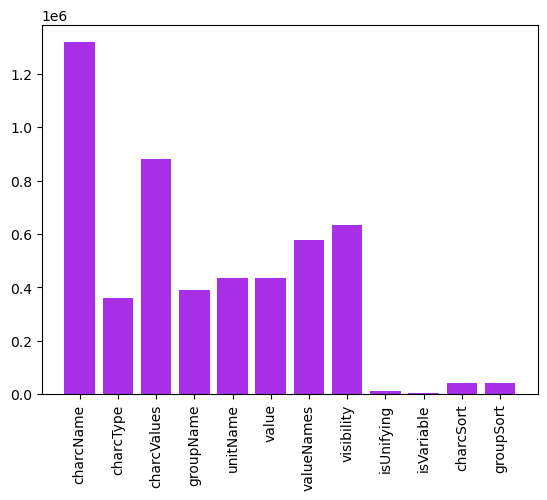

In [51]:
# Иллюстрируем

fig, ax = plt.subplots()
ax.bar(frequency_dict_total.keys(), frequency_dict_total.values(), color='#A82FE5')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

Как можно заметить, самое частотное свойство - само название характеристики. И верно, оно заполняется каждый раз, когда характеристика добавляется, соответственно, во всех случаях это свойство будет непустым. 

Второе по частотности свойство - charcValues, числовое измерение или содержание характеристики (например, длина упаковки или цвет).

Благодаря анализу частотности заполнения мы понимаем, какие подразделы характеристик будут малополезны. Те ключи, которые чаще всего оказываются пустыми, заполнены у малого количества товаров, а значит содержательной информации, которая позволит отличать товары между собой, из этой части характеристик мы не получим. С другой стороны, само наличие этих характеристик может сигнализировать о принадлежности товара к определенному классу (например, если подраздел характеристики заполнен у товаров, похожих между собой), и это можно использовать.

Проанализируем то, чем чаще всего заполняется наиболее частотный подраздел - charcNames:

In [52]:
def featName_list(charc, feature_Name):
    
    """
    Функция извлекает все значения, которые может принимать свойство характеристики для определенного товара по имени этого свойства.
    """
    
    featName_list = []
    for d in charc:
        if feature_Name in d.keys():
            featName_list.append(d[feature_Name])
    return featName_list

In [53]:
charcNames = char_train.apply(lambda char: featName_list(char, 'charcName'))

In [54]:
# Сложим все значения по всем товарам

char_train_charcNames_merged = []
for charc_list in charcNames:
    char_train_charcNames_merged += charc_list

In [55]:
charcNames

56869     [Страна производства, Серия, Высота упаковки, Вид бумаги, Обложка, Языки, Длина упаковки, Высота предмета, Наименование книги, Жанры/тематика, Количество страниц, Глубина предмета, Цикл, Год выпус...
116591                                     [Страна производства, Вес с упаковкой (кг), Количество нот, Высота предмета, Вес без упаковки (кг), Материал музыкального инструмента, Тип ксилофона, Ширина предмета]
122485    [Страна производства, ТНВЭД, Материал подкладки обуви, Длина упаковки, Особенности модели, Вид бутс, Полнота обуви (EUR), Тип покрытия, Материал стельки, Назначение обуви, Пол, Высота упаковки, Ши...
74678     [Пол, Вид застежки, Декоративные элементы, Длина упаковки, Страна производства, Высота упаковки, Карманы, Ширина предмета, Материал подкладки, Глубина предмета, Количество отделений, Ширина упаков...
109425                                   [Пол, Длина упаковки, Комплектация, Материал подкладки обуви, Ширина упаковки, Спортивное назначение, ТНВЭД, Страна про

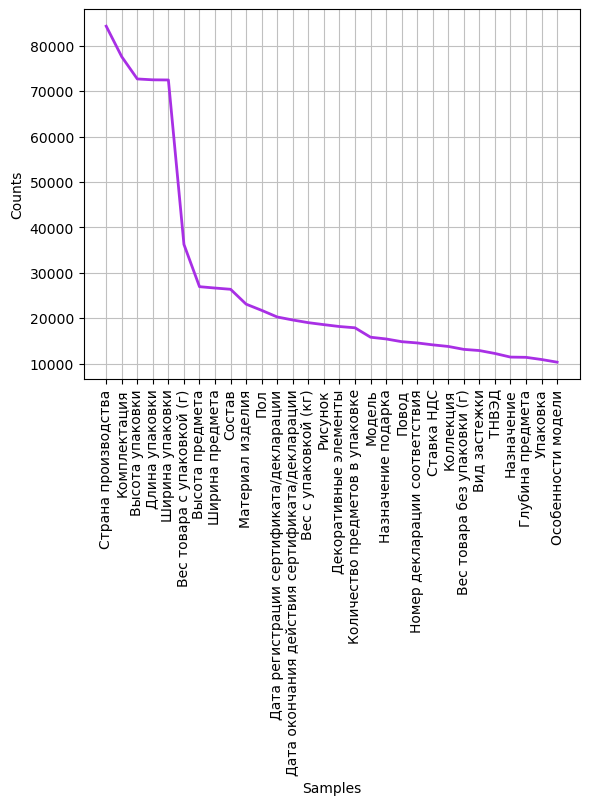

<Axes: xlabel='Samples', ylabel='Counts'>

In [56]:
# Иллюстрируем

fdist_char = FreqDist(char_train_charcNames_merged)
fdist_char.plot(30, cumulative=False, color = '#A82FE5')

Итак, из более 1,2 миллионов характеристик charcValues уникальными являются только 4,5 тысячи. Это сразу наталкивает нас на идею обработки характеристик: мы можем составить карту признаков, выделив наиболее частотные и полезные нам категории charcValues, и заполнить их как отдельные признаки товаров значениями из charcValues и ValueNames. Одна часть признаков будут категориальными (например, цвет), вторая часть - числовыми, третью часть, принимающую значения текстовых характеристик, будем обрабатывать через NLP модель, воспринимая за ключевые слова. (Также есть вариант слияния этой части с названием, возможно, такая обработка будет логичнее, так как содержательно и структурно названия и текстовые характеристики похожи.)

Анализ частотности charcNames сразу позволяет сложить представление о том, какие признаки присущи большинству товаров. Некоторые из них нам полезны - например, без сомнения, пол, некоторые - не очень, например, размеры упаковки (все-таки, на различие между товарами она не влияет, совершенно разные товары могут содержаться в упаковках одинакового размера).

Предположу, что самые частотные категории относятся к категориям WildBerries по умолчанию.

В любом случае, из характеристик можно извлечь очень много потенциально полезных данных, так как часть этих самых характеристик напрямую относит товар к категории, которую нам нужно будет определить при построении эмбеддингов.

Проанализируем оставшиеся данные в характеристиках, пронаблюдаем число уникальных значений и типы данных:

In [57]:
# Пример: ищем уникальные значения для valueNames

valueNames_list = char_train.apply(lambda char: featName_list(char, 'valueNames'))

vN_list_total = []
for charc_list in valueNames_list:
    vN_list_total += charc_list

clean_vN_list = list(filter(lambda s: s != 'None', vN_list_total))
len(clean_vN_list)

578154

Прошлая версия*

Опишем структуру характеристик по прошествии работы с ними:

                    "charcName": dtype = string, nunique_values = 4867, название характеристики
                    "charcSort": dtype = float, nunique_values = 69
                    "charcType": dtype = float, nunique_values = 4
                    "charcValues": dtype = string/np.array(), nunique_values = 882803, содержание характеристики (что, из чего, какой)
                    "groupName": dtype = string, nunique_values = 35,  группа характеристик (Технические особенности, Габариты)
                    "groupSort": dtype = float, nunique_values = 31
                    "isUnifying": bool,
                    "isVariable": bool,
                    "unitName": dtype = string, nunique_values = , единица измерения
                    "value": dtype = float/np.array(), nunique_values = , численное значение характеристики,
                    "valueNames": dtype=string/np.array(), nunique_values = 578154,
                    "visibility": bool}

Опишем наблюдения:

Большая часть характеристик заполнена у очень маленького числа товаров (почти в каждой карточке стоит 0/None). Внимание стоит обратить на charcValues и valueNames - они непосредственно хранят содержание характеристики и заполнены у большой части товаров (часто они взаимоисключающие, то есть взаимозаменяемые, предполагая это, мы можем соотнести для каждого charcName свой charcValues/valueNames, поставить в пару тип характеристики и содержание характеристики). Это будет основой для нашего будущего создания карты признаков.

Стоит заметить, что, как и было отмечено ранее, несмотря на редкость заполнения других подразделов, некоторые из них заполнены только у конкретного типа товаров: например, groupName, которая часто принимает значения Технические особенности, Особенности Интерфейса, Мультимедийные особенности и так далее, преимущественно заполнена только у электроники. Это мы так же сможем использовать в будущем.


# UPD: Полная расшифровка ключей характеристик:

1. charcName: название характеристики



2. charcSort: код характеристики внутри категории

В отличие от groupSort, разнится от товара к товару, но принимает близкие значения (например, страна производства 10-13, состав 5-6) - как я предполагаю, это порядковая нумерация характеристик внутри категории товара, то есть Вайлдберрис предлагает продавцу в зависимости от выбранной им категории заполнить n характеристик, они в целом расположены в одном порядке, но в силу наличия/отсутствия у определенных товаров тех или иных свойств, характеристики будут менять свой порядковый номер внутри категории. Технически, если составить карту соответствий, то можно тоже использовать как таргет, однако они заполнены далеко не у всех товаров, и это будет распространяться на относительно малую долю карточек.

5. charType: тип характеристики, помимо None/0.0 принимает только значения 1.0 (индивидуальные характеристики товара) и 4.0 (характеристики упаковки)

6. charcValues: содержание характеристики

7. groupName: название группы характеристик

8. groupSort: код группы характеристик (например: Габариты - 35, Материалы - 33, Технические особенности - 13, Общие характеристики - 1, None (отсутствие категории характеристик) - 34)

Этот ключ характеристик можно использовать как таргет, так как наличие определенной кодировки (тот факт, что эта характеристика вообще есть в карточке) свидетельствует о принадлежности к категории).

7. isUnifying: объединены ли характеристики под группой (groupName != None)

8. isVariable: имеет ли товар опциональную комплектацию (например, можно ли выбрать вкус/цвет/узор и так далее)

9. unitName: единица измерения числовых характеристик

10. value: значение числовых характеристик

11. valueNames: содержание характеристики - всегда дублирует charcValues, если не равно None. Причем charcValues заполнено гораздо чаще, чем valueNames. Таким образом, эта характеристика для нас бесполезна.

12. visibility: насколько я поняла, visibility показывает, выбрано ли содержание заполненной характеристики из выпадающего автоматически списка предложений на Вайлдберрис, или пользователь заполнил ее произвольным содержанием. Если характеристика выбрана из списка предложенных, то она будет отображаться при фильтрации товара в поиске (Visibility = True), если характеристика заполнена произвольным значением, то есть продавец не выбрал ничего из выпадающего списка, то эта характеристика не будет отображаться при фильтрации в поиске (Visibility = False).

Это приводит к тому, что характеристики с visibility = True стандартизированы, заполнены с использованием одинаковых слов, с одинаковым форматированием (в этом можно убедиться, просматривая данные), с такими характеристиками удобно работать, так как можно будет напрямую выделить категориальные значения, без поиска одних и тех же значений, написанных по-разному. А visibility = False заполнены с произвольным форматированием и нестандартизированным содержанием, для них понадобится поиск синонимов и дополнительная обработка. 

Так же в группу с visibility = False попадают те категории характеристик, которые по умолчанию не будут отображаться при фильтрации в поиске и не видны покупателям. Например, назначение может быть заполнено стандартизировано, но на маркетплейсе в карточках оно не отображается.

# UPD: 4. Анализ изображений

Выгрузим 6000 случайно выбранных изображений датасета (5% всего датасета, для скорости обработки) через OpenCV для автоматического прочтения в BGR формате.

Перед началом работы с любой моделью может понадобиться препроцессинг картинок: необходимо определить их особенности, чтобы понять, какие шаги препроцессинга потребуются.

Проанализируем хроматические характеристики картинок.

In [58]:
images = []
for f in glob.iglob("/Users/alina/Desktop/sample_images/*"):
    images.append(cv2.imread(f))

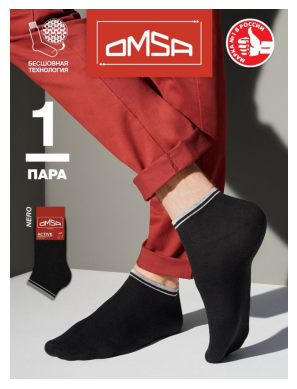

In [59]:
plt.axis('off')
plt.imshow(images[99])

Определим яркость картинок:

In [61]:
def brightness(img):

    """
    Функция определяет среднюю яркость на пиксель изображения путем нахождения среднего геометрического. 
    """
    
    if len(img.shape) == 3:
        # Если картинка цветная
        return np.average(np.linalg.norm(img, axis=2)) / np.sqrt(3)
    else:
        # Если картинка монохромная
        return np.average(img)

In [62]:
brightness_frequency = []
for img in images:
    brightness_frequency.append(brightness(img))

(array([  10.,   52.,  102.,  231.,  401.,  652.,  988., 1404., 1495.,
         839.]),
 array([ 14.07070176,  38.16363158,  62.25656141,  86.34949123,
        110.44242105, 134.53535088, 158.6282807 , 182.72121053,
        206.81414035, 230.90707018, 255.        ]),
 <BarContainer object of 10 artists>)

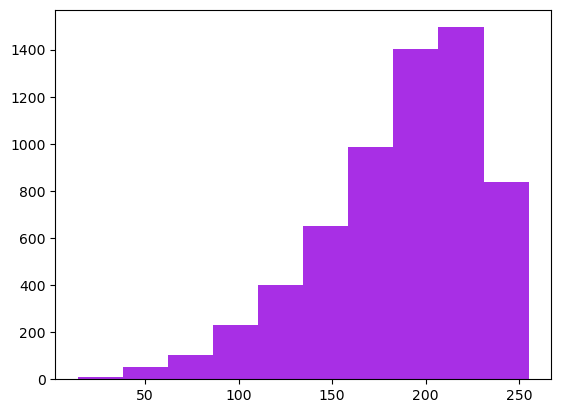

In [63]:
plt.hist(brightness_frequency, color='#A82FE5')

Видим, что яркость смещена ближе к максимальным значениям. Это может говорить о том, что картинки слишком засвечены, в таком случае, изображения разных товаров будут мало отличаться, детекция объектов будет затруднена, и нам понадобится нормализоваьт их яркость, приведя ее к средним значениям. Для того, чтобы понять, действительно ли картинки засвечены, оценим контрастность датасета:

In [64]:
def contrast(image):
    
    """
    Функция высчитывает значение контрастности картинки, переводя ее в grayscale формат и возвращая стандартное отклонение.
    """
    
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return img_grey.std()

In [65]:
contrast_distribution = []
for img in images:
    contrast_distribution.append(contrast(img))

(array([  26.,  166.,  476.,  974., 1486., 1413.,  979.,  480.,  163.,
          11.]),
 array([  0.        ,  12.5014058 ,  25.00281159,  37.50421739,
         50.00562319,  62.50702899,  75.00843478,  87.50984058,
        100.01124638, 112.51265218, 125.01405797]),
 <BarContainer object of 10 artists>)

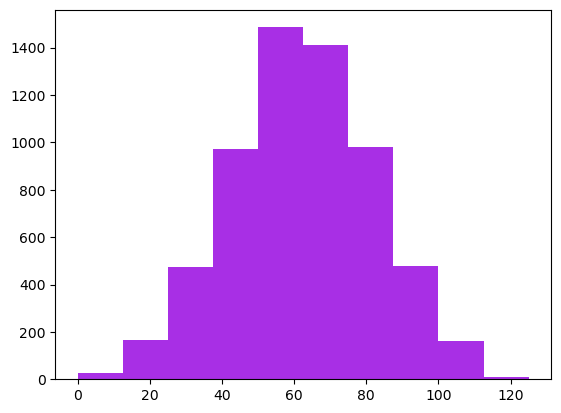

In [66]:
plt.hist(contrast_distribution, color='#A82FE5')

Контрастность на большинстве изображений средняя. Это говорит о том, что по крайней мере большая часть картинок не засвечена, и объекты на них будут распознаны. Тогда яркость, скорее всего, вызвана большим количеством белого цвета на изображениях: например, при просмотре датасета вручную можно заметить, что на подавляющем числе изображений фон белый (товар расположен в центре на белом фоне, например, либо модель позирует на белом фоне). 

Также стоит отметить, что в датасете все же присутствуют картинки с очень низкой контрастностью (как пример, это может быть белая электрическая зубная щетка на белом фоне), и эти картинки могут снижать качество модели, которая будет обрабатывать изображения. Из этого можно сделать вывод, что некоторый препроцессинг со стандартизацией контрастности все-таки нужен.


Например, изображение нашего датасета номер 596 имеет низкую контрастность, стандартное отклонение яркости на уровне 6:

In [67]:
contrast_distribution[596]

6.194837452882896

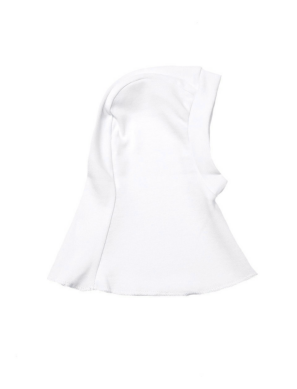

In [68]:
plt.axis('off')
plt.imshow(images[596])

Нормализуем контрастность:

In [71]:
p01, p98 = np.percentile(images[596], (0.1, 98))
img_cs = ski.img_as_float(ski.exposure.rescale_intensity(images[596], in_range=(p01, p98)))

(-0.5, 899.5, 1199.5, -0.5)

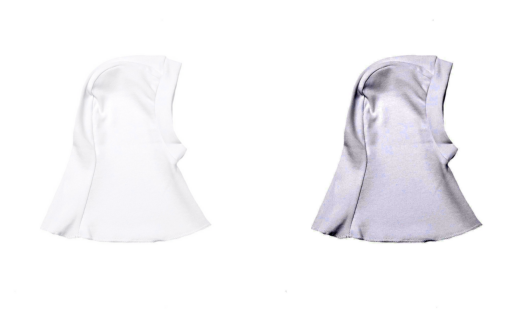

In [118]:
f, (ax0, ax1) = plt.subplots(1,2) 

ax0.imshow(images[596])
ax0.axis('off')
ax1.imshow(img_cs)
ax1.axis('off')

Получаем более различимое изображение. Важно при этом подобрать параметры так, чтобы минимизировать искажение цвета.

Посмотрим на распределение значений цветовых каналов, чтобы подтвердить или опровергнуть гипотезу про большое количество белого цвета:

In [107]:
b_distribution = []
for img in images:
    b_distribution.append(cv2.calcHist(img[:,:,0], [0], None,[256],[0,256]))

In [108]:
g_distribution = []
for img in images:
    g_distribution.append(cv2.calcHist(img[:,:,1], [1], None,[256],[0,256]))

In [109]:
r_distribution = []
for img in images:
    r_distribution.append(cv2.calcHist(img[:,:,2], [2], None,[256],[0,256]))

Находим среднее между гистограммами для всех картинок датасета, иллюстрируем

<Figure size 640x480 with 0 Axes>

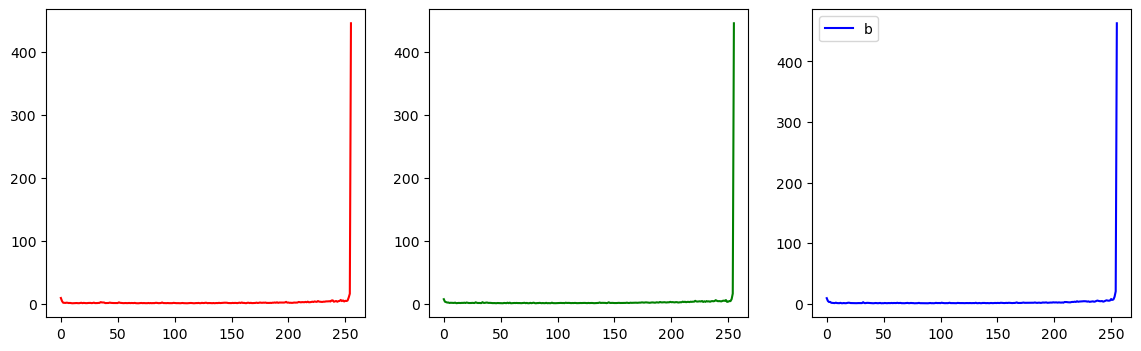

In [120]:
plt.figure()

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (14,4)) 

ax0.plot(np.mean(r_distribution, axis = 0), color='r', label='r')
ax1.plot(np.mean(g_distribution, axis = 0), color='g', label='g')
ax2.plot(np.mean(b_distribution, axis = 0), color='b', label='b')

plt.legend()
plt.show()

Распределения цветов почти одинаковые, с большим подскоком на максимальном значении, также есть небольшое увеличение на (0, 0, 0), черном цвете.

In [119]:
colour_distributions = []
for img in images:
    colour_distribution = np.bincount(img.flatten(), minlength=256)
    colour_distributions.append(colour_distribution)
    
colour_distributions = np.array(colour_distributions)

In [121]:
mean_colour_distribution = np.mean(colour_distributions, axis=0)

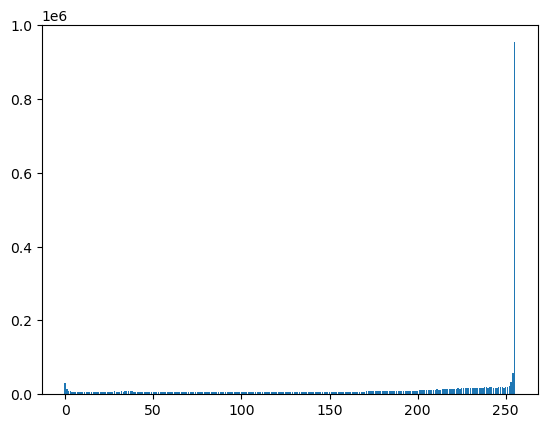

In [122]:
plt.bar(np.arange(256), mean_colour_distribution)
plt.show()

Как можно заметить, значения цветовых каналов и, как следствие, среднее цветовое значение очень сильно смещены в право: максимальное значение принимается очень часто. Цвет (255, 255, 255) - белый цвет, это подтверждает, что на картинках доминирует белый оттенок в основном. В сочетании со средней контрастностью это говорит о большом количестве картинок с белым фоном, по всей видимости.

В завершение посмотрим на доминантные цвета в датасете, подтвердив увиденные раннее наблюдения:

In [124]:
def dominant_colour_frequency(img):

    """
    Функция определяет доминантный цвет изображения.
    """
    
    img2D = img.reshape(-1,img.shape[-1])
    col_range = (256, 256, 256)
    img1D = np.ravel_multi_index(img2D.T, col_range)
    return np.unravel_index(np.bincount(img1D).argmax(), col_range)

In [125]:
dominant_colours = []
for img in images:
    dominant_colours.append(dominant_colour_frequency(img))

In [126]:
counter = Counter(dominant_colours)

<Figure size 640x480 with 0 Axes>

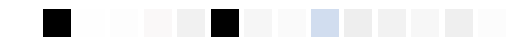

In [127]:
plt.figure()
f, axarr = plt.subplots(1,15) 
for i in range(15):
    axarr[i].imshow([[counter.most_common(15)[i][0]]])
    axarr[i].axis('off')

И действительно, оттенки белого в 80% случаев являются доминантным цветом на изображениях (так же замечаем 2 черных оттенка, близких к наиболее частотным).
В целом, это плюс нашего датасета: нам не придется убирать фон для лучшей детекции объектов, они удобно расположены в центре картинок и часто хорошо контрастируют на белом фоне, поэтому данные почти не нуждаются в препроцессинге.

Так же я пропустила датасет через Cisdem Duplicate Finder, и он выявил, что около 3% датасета изображений (3500 штук) - дубликаты (идентификаторы различны, картинки идентичны). Важно сохранить эти изображения, чтобы потом они в нужных пропорциях попали в тренировочные и валидационные выборки. 

### Часть анализа изображений с предыдущей версии ноутбука:

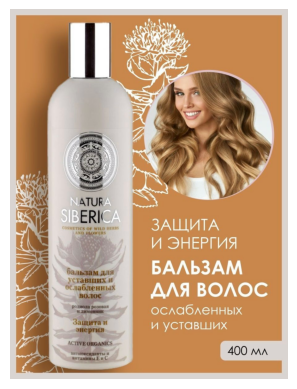

In [13]:
image_link = '/Users/alina/Downloads/wb_school_horizcv_images/2055815.jpg'
image = Image.open(image_link)
opencvImage = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
plt.axis("off")
plt.imshow(opencvImage)
im_pil = Image.fromarray(opencvImage)

In [5]:
path = '/Users/alina/Downloads/wb_images'
train_img = []

In [6]:
for img in os.listdir(path):
    pic = cv2.imread(os.path.join(path,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(240,240))
    train_img.append([pic])

error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [8]:
train_img[0]

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [77]:
np.save(os.path.join(path,'train_img'),np.array(train_img))
saved = np.load(os.path.join(path,'train_img.npy'))

(-0.5, 239.5, 239.5, -0.5)

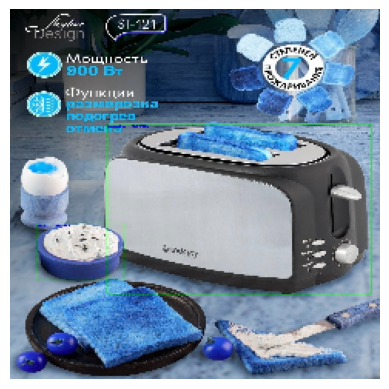

In [81]:
# Пример картинки из фрагментарного датасета:

plt.imshow(saved[0].reshape(240,240,3))
plt.imshow(np.array(train_img[5]).reshape(240,240,3))
plt.axis("off")

Из исследовательского интереса попробуем взглянуть, как происходит детекция объектов на этих картинках с помощью предобученной на датасете COCO модели RetinaNet (и дефолтными классами):

Изначально я хотела посмотреть примерную частоту появления объектов, статистику по распознаванию в качестве первичного анализа изображений, но в последствии пришла к выводу, что это требует более тщательно подбора предобученной модели, поэтому выбор и оценку самой модели лучше отложить до предназначенного для этого второго этапа. В любом случае, интересно посмотреть, столкнемся ли мы с чем-то показательным или необычным при пробе пера.

In [82]:
model_path = '/Users/alina/Downloads'

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath(os.path.join(model_path,'retinanet_resnet50_fpn_coco-eeacb38b.pth'))
detector.loadModel()

In [83]:
detections = []
filenames = next(os.walk(path))[2]

In [84]:
# Из соображений экономии ресурсов, посмотрим на 100 картинок фрагментарного датасета:

for img in filenames[:101]:
    detection = detector.detectObjectsFromImage(input_image=os.path.join(path,img), output_image_path=os.path.join(path , img))
    detections.append(detection)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [85]:
detections

[[{'name': 'person',
   'percentage_probability': 91.04,
   'box_points': [282, 21, 608, 1179]}],
 [],
 [{'name': 'cat',
   'percentage_probability': 92.89,
   'box_points': [645, 692, 875, 819]},
  {'name': 'cat',
   'percentage_probability': 85.13,
   'box_points': [493, 363, 705, 518]},
  {'name': 'cat',
   'percentage_probability': 81.14,
   'box_points': [699, 507, 871, 666]},
  {'name': 'cat',
   'percentage_probability': 77.51,
   'box_points': [674, 164, 829, 341]},
  {'name': 'person',
   'percentage_probability': 59.73,
   'box_points': [209, 441, 412, 576]}],
 [{'name': 'person',
   'percentage_probability': 85.17,
   'box_points': [23, 14, 889, 1196]}],
 [{'name': 'suitcase',
   'percentage_probability': 66.11,
   'box_points': [52, 525, 206, 785]},
  {'name': 'suitcase',
   'percentage_probability': 65.3,
   'box_points': [146, 499, 295, 743]},
  {'name': 'suitcase',
   'percentage_probability': 64.97,
   'box_points': [99, 511, 257, 769]},
  {'name': 'handbag',
   'percen

Список наблюдений здесь совпадает с порядком отображений фото из фрагментарного датасета, который я выгрузила выше.

Пусть на данном этапе нельзя провести полноценный анализ того, насколько в целом объекты можно определять или нет, какой потенциал имеют картинки, ведь модель выбрана почти наугад и обучена на данных, которые достаточно далеки от нашего датасета, можно подтвердить догадки по поводу того, что инверсия цвета мешает детекции объектов. Например, RetinaNet не смогла идентифицировать апельсин (который есть у нее в дефолтных классах), так как на картинке он голубого цвета. (пример ниже)

Людей инверсия цвета преимущественно идентифицировать не мешает, однако так же вводит в заблуждение. Например женский глаз на фоне голубой кожи модель приняла за птицу (на фоне неба, как я предполагаю).

In [86]:
# Отсутствуют предположения о примере номер 100
detections[99]

[]

(-0.5, 239.5, 239.5, -0.5)

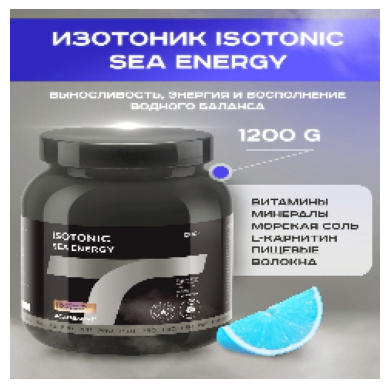

In [87]:
# На картинке номер 100 изображен апельсин

plt.imshow(np.array(train_img[99]).reshape(240,240,3))
plt.axis("off")

Все фото одного размера - 900x1200.
Всего их 125 812.